In [2]:
import os
import os.path as op
import boto3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
import skimage.morphology
from skimage.filters import try_all_threshold
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import resize
from skimage import measure
from skan import csr
from skan import summarize
from skan import draw 

In [12]:
#Formats and prepares the 
image_list = []
name = "Slide1_section3_60x_zstack" #Change the file name to the image's file in tif
zstacks = 2 #Change the number to the number of images being coded
for image in range(1, zstacks+1): 
    image_list.append(name+"{}".format(image))

In [ ]:
image_list

                       image-id skeleton-id # of branches  tot. branch length  \
1   Slide1_section3_60x_zstack5           1            34          356.263357   
2   Slide1_section3_60x_zstack5           2            34          389.624090   
3   Slide1_section3_60x_zstack5           3             7           70.019451   
4   Slide1_section3_60x_zstack5           4            38          510.271697   
5   Slide1_section3_60x_zstack5           5            28          311.415204   
6   Slide1_section3_60x_zstack5           6             9          129.596513   
7   Slide1_section3_60x_zstack5           7            38          525.489149   
8   Slide1_section3_60x_zstack5           8            13          190.445957   
9   Slide1_section3_60x_zstack5           9            27          296.414347   
10  Slide1_section3_60x_zstack5          10            19          154.923972   
11  Slide1_section3_60x_zstack6           1            12          106.402917   
12  Slide1_section3_60x_zsta

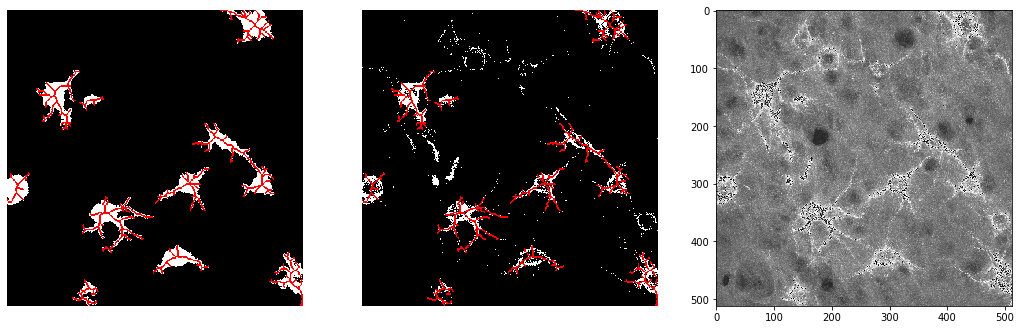

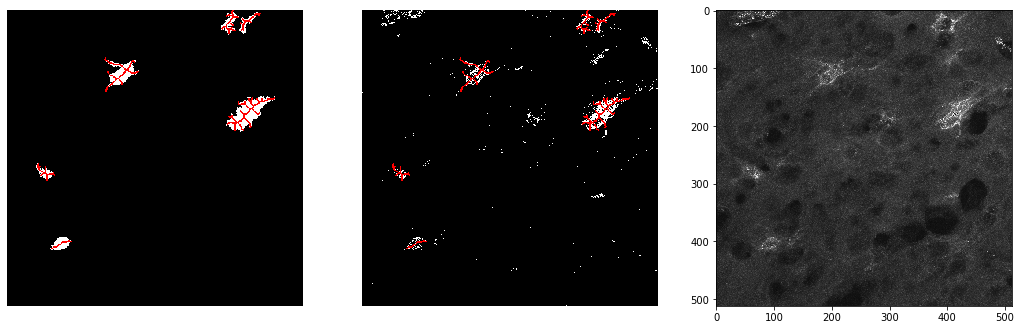

In [23]:
running_total = 0
skel_data = ["image-id","skeleton-id","# of branches","tot. branch length","avg. branch length"]
output_data = pd.DataFrame(columns = skel_data)

for images in image_list:
    img = skimage.io.imread("{}.tif".format(images))
    DAPI = img[0::3]
    PNN = img[1::3]
    PVA = img[2::3]
    DAPI_Max = np.max(DAPI,axis=0)
    PNN_Max = np.max(PNN,axis=0)
    PVA_Max = np.max(PVA,axis=0)
    thresh = skimage.filters.threshold_triangle(PNN_Max)
    pnnbinary = PNN_Max > thresh
    
    pnn_dilate = skimage.morphology.dilation(pnnbinary)
    dilate_hole = ndi.binary_fill_holes(pnn_dilate)
    
    Background_remove = skimage.morphology.remove_small_objects(dilate_hole, min_size = 400)
    
    skeleton = skimage.morphology.skeletonize(Background_remove)
    partial_skeleton = skimage.morphology.thin(Background_remove, max_iter = 2)
    
    clean_skeleton = skimage.morphology.remove_small_objects(partial_skeleton, min_size = 400)
    
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18,18))
    ax = axes.ravel()
    draw.overlay_skeleton_2d(Background_remove, skeleton, dilate = 1, axes = ax[0])
    draw.overlay_skeleton_2d(pnnbinary, skeleton, dilate = 1, axes = ax[1])
    ax[2] = plt.imshow(1-PNN_Max*80, cmap = "Greys")
    
    branch_data = csr.summarise(skeleton)
    
    num_skel = max(branch_data["skeleton-id"])
    tot_branch = len(branch_data)
    image_id = images
    for skels in range(1,num_skel+1):
        num_branch = 0
        tot_length = 0 
        for branch in range(0,tot_branch):
            if branch_data["skeleton-id"][branch] == skels:
                num_branch = num_branch+1
                tot_length = tot_length + branch_data["branch-distance"][branch]
        avg_length = tot_length/num_branch
        running_total = running_total+1
        output_data.loc[running_total] = [image_id, skels, num_branch, tot_length, avg_length]

print(output_data)
output_data.to_csv(name + ".csv",index = False, header = True)